In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab import drive
#drive.mount('/content/drive')



In [91]:
train_path = 'C:/Users/DELL/Desktop/rossmann-store-sales/train.csv'
store_path = 'C:/Users/DELL/Desktop/rossmann-store-sales/store.csv'

# Load datasets
train = pd.read_csv(train_path, parse_dates=['Date'], low_memory=False)
store = pd.read_csv(store_path)

# Merge train with store information
df = pd.merge(train, store, on='Store', how='left')

# Basic Info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [92]:
import numpy as np

print(df.shape)
print(df["Date"].min(), df["Date"].max())
print(df.isna().mean().sort_values(ascending=False).head(25))
print(df.describe(include="all").T.head(25))

(1017209, 18)
2013-01-01 00:00:00 2015-07-31 00:00:00
Promo2SinceWeek              0.499436
PromoInterval                0.499436
Promo2SinceYear              0.499436
CompetitionOpenSinceYear     0.317878
CompetitionOpenSinceMonth    0.317878
CompetitionDistance          0.002597
DayOfWeek                    0.000000
Store                        0.000000
Date                         0.000000
Sales                        0.000000
StoreType                    0.000000
SchoolHoliday                0.000000
StateHoliday                 0.000000
Promo                        0.000000
Open                         0.000000
Customers                    0.000000
Assortment                   0.000000
Promo2                       0.000000
dtype: float64
                               count unique              top    freq  \
Store                      1017209.0    NaN              NaN     NaN   
DayOfWeek                  1017209.0    NaN              NaN     NaN   
Date                         10

In this step, we convert Date to a datetime format and extract calendar-based features such as year, month, day, and week number. Then, the holiday indicators (StateHoliday and SchoolHoliday) are encoded into numeric values. Finally, after sorting by store and date, we compute 7-day and 30-day moving averages of sales using only previous days (shift(1)) to avoid data leakage.

In [104]:
df = df.sort_values(["Store","Date"]).reset_index(drop=True)

g = df.groupby("Store")["Sales"]

df["SalesLag1"] = g.shift(1)
df["SalesLag7"] = g.shift(7)

s1 = g.shift(1)
df["SalesMean7"] = s1.groupby(df["Store"]).rolling(7, min_periods=1).mean().reset_index(level=0, drop=True)
df["SalesStd7"] = s1.groupby(df["Store"]).rolling(7, min_periods=2).std().reset_index(level=0, drop=True)

df["SalesMean30"] = s1.groupby(df["Store"]).rolling(30, min_periods=1).mean().reset_index(level=0, drop=True)
df["SalesStd30"] = s1.groupby(df["Store"]).rolling(30, min_periods=2).std().reset_index(level=0, drop=True)

df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek0,WeekOfYear,SalesMovingAverage7,SalesMovingAverage30,SalesLag1,SalesLag7,SalesMean7,SalesStd7,SalesMean30,SalesStd30
0,1,2,2013-01-01,0,0,0,0,1,1,c,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3,2013-01-02,5530,668,1,0,0,1,c,...,2,1,0.000000,0.000000,0.0,NaN,0.000000,NaN,0.000000,NaN
2,1,4,2013-01-03,4327,578,1,0,0,1,c,...,3,1,2765.000000,2765.000000,5530.0,NaN,2765.000000,3910.300500,2765.000000,3910.300500
3,1,5,2013-01-04,4486,619,1,0,0,1,c,...,4,1,3285.666667,3285.666667,4327.0,NaN,3285.666667,2908.351137,3285.666667,2908.351137
4,1,6,2013-01-05,4997,635,1,0,0,1,c,...,5,1,3585.750000,3585.750000,4486.0,NaN,3585.750000,2449.327306,3585.750000,2449.327306


To prevent the moving averages from becoming zero in the first days, we computed rolling features with min_periods=1 (and min_periods=2 for standard deviation), so the statistics are calculated using whatever history is available instead of producing NaNs that would later be filled with zeros.

In [105]:
df[['Store', 'Date', 'Sales', 'SalesLag1','SalesLag7', 'SalesMean7', 'SalesStd7','SalesMean30','SalesStd30']].head(10)

,Store,Date,Sales,SalesLag1,SalesLag7,SalesMean7,SalesStd7,SalesMean30,SalesStd30
0,1,2013-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-02,5530,0.0,NaN,0.000000,NaN,0.000000,NaN
2,1,2013-01-03,4327,5530.0,NaN,2765.000000,3910.300500,2765.000000,3910.300500
3,1,2013-01-04,4486,4327.0,NaN,3285.666667,2908.351137,3285.666667,2908.351137
4,1,2013-01-05,4997,4486.0,NaN,3585.750000,2449.327306,3585.750000,2449.327306
5,1,2013-01-06,0,4997.0,NaN,3868.000000,2213.081223,3868.000000,2213.081223
6,1,2013-01-07,7176,0.0,NaN,3223.333333,2532.144045,3223.333333,2532.144045
7,1,2013-01-08,5580,7176.0,0.0,3788.000000,2752.283961,3788.000000,2752.283961
8,1,2013-01-09,5471,5580.0,5530.0,4585.142857,2231.018633,4012.000000,2625.704205
9,1,2013-01-10,4892,5471.0,4327.0,4576.714286,2226.961885,4174.111111,2503.807573


In [106]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'DayOfWeek0', 'WeekOfYear', 'SalesMovingAverage7',
       'SalesMovingAverage30', 'SalesLag1', 'SalesLag7', 'SalesMean7',
       'SalesStd7', 'SalesMean30', 'SalesStd30'],
      dtype='object')



> We also added 30-day rolling statistics based only on past sales: SalesMean30 (30-day rolling mean) and SalesStd30 (30-day rolling standard deviation) computed per store using shifted sales to avoid leakage.



We build Fourier seasonal features using DayOfYear. The terms sin_1y/cos_1y capture the main annual (1-year) seasonality while sin_2y/cos_2y model more complex within-year patterns (e.g., two peaks during the year).

We implemented two independent normalization strategies in separate cells. First, we created df_z and applied Z-score standardization only to non-binary numeric features (leaving 0/1 indicators unchanged), so those features have approximately zero mean and unit variance. Second, we created df_mm and applied Min–Max normalization to scale numeric features into the [0,1] range. Using separate copies ensures the two normalizations do not affect each other

We split the dataset into train/validation/test while strictly preserving chronological order. To avoid any date overlap (since each date contains many stores/rows), we performed the split using the unique dates rather than row indices. This guarantees monotonic time ordering and ensures that the validation and test sets contain only future dates relative to the training set (no temporal leakage).

In [107]:
df_model = df.dropna().reset_index(drop=True)

In [108]:
df_model.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'DayOfWeek0', 'WeekOfYear', 'SalesMovingAverage7',
       'SalesMovingAverage30', 'SalesLag1', 'SalesLag7', 'SalesMean7',
       'SalesStd7', 'SalesMean30', 'SalesStd30'],
      dtype='object')

In [109]:
from sklearn.preprocessing import LabelEncoder

# 1. Find all columns with text type (object)
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns to encode:", categorical_cols.tolist())

# 2. Convert text columns to numeric values using LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    # Convert missing values (NaN) to a temporary string to avoid errors
    df[col] = df[col].fillna('Missing').astype(str)
    # Convert text to numbers (e.g. a=0, b=1, c=2)
    df[col] = le.fit_transform(df[col])

# 3. (Optional) Fill remaining missing (NaN) values in numeric columns
# Because models like Random Forest have issues with NaN values
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(-999)

print("Data preprocessing completed. No 'object' columns left.")


Categorical columns to encode: ['StoreType', 'Assortment', 'PromoInterval']
Data preprocessing completed. No 'object' columns left.


Part 1: Implementing Multi-step Forecasting for the Next 7 Days with Error Propagation Management

Question Analysis:
Multi-step forecasting means that at day 𝑡, we want to predict sales for days 𝑡+1 through t+7.

The term “Error Propagation Management” means that we should avoid simple recursive methods (i.e., using tomorrow’s prediction as an input to predict the day after tomorrow), because model errors accumulate rapidly in this approach.

The best practice here is to use the Direct Method or Multi-Output Models.

Solution:

Create 7 new target variables for the next 7 days and use a MultiOutputRegressor.

In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# 1. Sort the dataset by Store and Date (very important for time series)
df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)

# 2. Create target variables (Target) for the next 7 days
# Negative shift means bringing future values to the current row
for i in range(1, 8):
    df[f'Sales_step_{i}'] = df.groupby('Store')['Sales'].shift(-i)

# Remove rows where future targets (last days) have NaN values
df_multi = df.dropna(subset=[f'Sales_step_{i}' for i in range(1, 8)])

# 3. Select features (X) and targets (Y)
# We use all available features at time t as input
drop_cols = ['Date', 'Sales'] + [f'Sales_step_{i}' for i in range(1, 8)]
X = df_multi.drop(columns=drop_cols)
y = df_multi[[f'Sales_step_{i}' for i in range(1, 8)]]

# Split the data into train and test sets
# Since this is a time series, we must not shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Build and train a Multi-Output XGBoost model
# This trains an independent model for each forecast horizon (1 to 7) to avoid error propagation
base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
multi_model = MultiOutputRegressor(base_model)

multi_model.fit(X_train, y_train)

# 5. Prediction and evaluation
predictions = multi_model.predict(X_test)
print("MAE for 7-day multi-step forecasting:", mean_absolute_error(y_test, predictions))


MAE for 7-day multi-step forecasting: 782.3892211914062


Part 2: Uncertainty Estimation using Quantile Regression or Ensemble Methods

Question Analysis:

Instead of predicting just a single number for sales (a point estimate), we should provide an interval — for example, saying “with 80% confidence, tomorrow’s sales will be between 5000 and 7000.”

The professor suggested using Quantile Regression or an Ensemble approach.

LightGBM inherently supports Quantile Regression by adjusting its loss function, which makes the implementation clean and standard.

Solution:

Train three separate LightGBM models for quantiles 10 (lower bound), 50 (median prediction), and 90 (upper bound).

   Lower_Bound (10%)  Median_Forecast (50%)  Upper_Bound (90%)  Actual
0        5635.655697            6099.097330        6725.037544    6460
1        4993.714663            5716.971135        5574.327677    4983
2           0.000000               0.152091          23.331902       0
3           0.000000               0.152091        1363.434710       0
4        9307.239145           10696.283556       11894.418704   10011


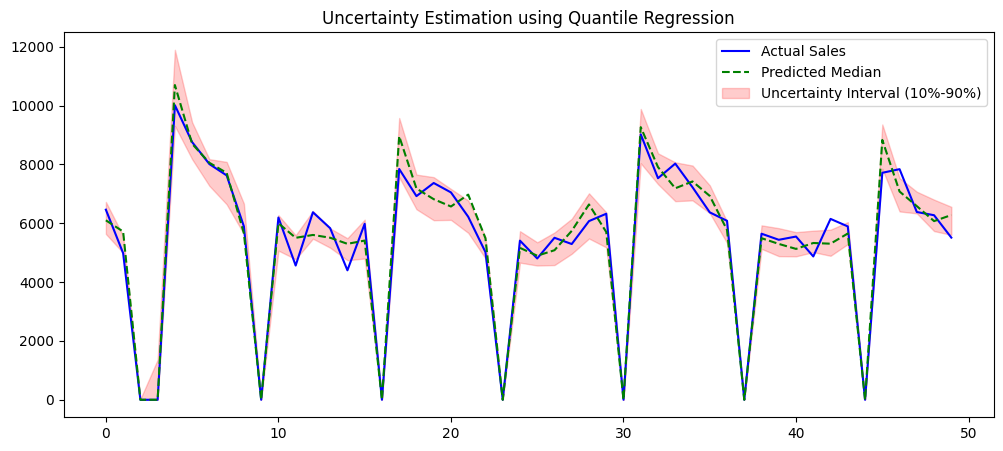

In [111]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# In this section, we assume that our goal is to predict next-day sales (Sales).
X_unc = df.dropna().drop(columns=['Date', 'Sales'])
y_unc = df.dropna()['Sales']

# Split the data into training and test sets (no shuffling since it's a time series)
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X_unc, y_unc, test_size=0.2, shuffle=False
)

# Define quantiles (10% for pessimistic, 50% for normal, 90% for optimistic scenario)
quantiles = [0.1, 0.5, 0.9]
models = {}
predictions_q = {}

for alpha in quantiles:
    # The key part: set objective='quantile' and parameter alpha
    model = lgb.LGBMRegressor(objective='quantile', alpha=alpha, n_estimators=100)
    model.fit(X_train_u, y_train_u)
    models[alpha] = model
    predictions_q[alpha] = model.predict(X_test_u)

# Now, for each test row, we have three predicted values
preds_df = pd.DataFrame({
    'Lower_Bound (10%)': predictions_q[0.1],
    'Median_Forecast (50%)': predictions_q[0.5],
    'Upper_Bound (90%)': predictions_q[0.9],
    'Actual': y_test_u.values
})

print(preds_df.head())

# (Optional) Plot the uncertainty interval for the first 50 test samples
plt.figure(figsize=(12, 5))
plt.plot(preds_df['Actual'][:50], label='Actual Sales', color='blue')
plt.plot(
    preds_df['Median_Forecast (50%)'][:50],
    label='Predicted Median',
    color='green',
    linestyle='--'
)
plt.fill_between(
    range(50),
    preds_df['Lower_Bound (10%)'][:50],
    preds_df['Upper_Bound (90%)'][:50],
    color='red',
    alpha=0.2,
    label='Uncertainty Interval (10%-90%)'
)
plt.legend()
plt.title("Uncertainty Estimation using Quantile Regression")
plt.show()


Part 3: Sales Classification into Three Categories (Low, Medium, High) and Evaluation using ROC-AUC and F1-Score
Question Analysis:
You need to transform the continuous Sales variable into three distinct categories — Low, Medium, and High.

Then, train a multi-class classification model and evaluate its performance using the required metrics.

Solution:

Use the pd.qcut function to create balanced classes, and then train a classifier such as RandomForestClassifier or XGBClassifier.

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# 1. Convert continuous Sales variable into 3 categories (Low=0, Medium=1, High=2)
# The qcut function divides the data into three bins with approximately equal frequencies.
# Note: You may want to handle days when the store was closed and sales were zero separately.
# But in general:
df_class = df.copy()
df_class['Sales_Class'] = pd.qcut(df_class['Sales'], q=3, labels=[0, 1, 2])

# 2. Prepare data for the model
X_clf = df_class.drop(columns=['Date', 'Sales', 'Sales_Class'])
X_clf = X_clf.fillna(-999)  # Fill missing values for tree-based models
y_clf = df_class['Sales_Class']

# Split the data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# 3. Train the multi-class classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
classifier.fit(X_train_c, y_train_c)

# 4. Prediction
# For F1-score, we need class labels
y_pred_class = classifier.predict(X_test_c)

# For multi-class ROC-AUC, we need probabilities
y_pred_proba = classifier.predict_proba(X_test_c)

# 5. Compute metrics
# For multi-class problems, you must specify the averaging method (macro or weighted)
f1 = f1_score(y_test_c, y_pred_class, average='weighted')

# For multi-class ROC-AUC, the parameter multi_class='ovr' (One-vs-Rest) is required
roc_auc = roc_auc_score(y_test_c, y_pred_proba, multi_class='ovr', average='weighted')

print("--- Multi-class Classification Results ---")
print(f"F1-Score (Weighted): {f1:.4f}")
print(f"ROC-AUC (OVR, Weighted): {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_class, target_names=['Low', 'Medium', 'High']))


--- Multi-class Classification Results ---
F1-Score (Weighted): 0.9180
ROC-AUC (OVR, Weighted): 0.9869

Classification Report:
               precision    recall  f1-score   support

         Low       0.95      0.94      0.95     67829
      Medium       0.87      0.89      0.88     67846
        High       0.93      0.93      0.93     67767

    accuracy                           0.92    203442
   macro avg       0.92      0.92      0.92    203442
weighted avg       0.92      0.92      0.92    203442

